 # ECG Validation Notebook

 Validation of RF and CNN models on held-out data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import neurokit2 as nk
import joblib
from pathlib import Path
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import custom modules
from data_processing import load_processed_data
import RF_pipeline
import CNN_pipeline


 ## 1. Load Validation Data

In [2]:
# Load validation indices
val_indices = np.load('./Results/val_indices.npy', allow_pickle=True)
np.random.seed(42)  # Set seed
val_indices = np.random.choice(val_indices, size=int(len(val_indices)*0.2), replace=False)
print(f'Validation data: {len(val_indices)}')

Validation data: 6321


In [3]:
# Load processed data
data_path = '/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data'
ecg_data, patient_data = load_processed_data(data_path, val_indices)

# Filter validation data
val_data = patient_data.loc[val_indices]
val_ecg = {k: v['ecg_signals_filtered'] for k, v in ecg_data.items() if k in val_indices}

del ecg_data  # Free memory

Using 7 CPUs for parallel processing
Loading data from: /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data/processed_20250115_132555


Loading patient data: 100%|██████████| 6321/6321 [00:18<00:00, 350.13patient/s]


Successfully loaded 6321 out of 6321 patients from /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data/processed_20250115_132555
2025-01-22 23:42:03 - load_processed_data took 0.34 minutes


 ## 2. Label categorization/encoding and filtering

In [4]:
def classify_cardiac_condition(diagnosis_codes):
    normal_codes = ['426783006']
    arrhythmia_codes = ['49436004', '164889003', '427172004', '426761007', 
                       '284470004', '164896001', '195126007', '251146004', '427393009']
    conduction_codes = ['59118001', '28189009', '270492004', '445211001', '27885002']
    structural_codes = ['22298006', '164865005', '164867002', '164873001', '164874007']
    
    if any(code in diagnosis_codes for code in normal_codes):
        return 'Normal'
    elif any(code in diagnosis_codes for code in arrhythmia_codes):
        return 'Arrhythmia'
    elif any(code in diagnosis_codes for code in conduction_codes):
        return 'Conduction'
    elif any(code in diagnosis_codes for code in structural_codes):
        return 'Structural'
    else:
        return 'Other'

# Apply classification
val_data['cardiac_condition'] = val_data['diagnosis_code'].apply(classify_cardiac_condition)

# Filter out 'Other' category
val_data_filtered = val_data[val_data['cardiac_condition'] != 'Other']
val_ecg_filtered = {k: v for k, v in val_ecg.items() if k in val_data_filtered.index}

 ## 3. Prepare Data for RF Model

In [5]:
# Calculate HRV metrics
def calculate_hr_metrics(rpeaks, fs):
    rr_intervals = np.diff(rpeaks) / fs
    hr = 60 / rr_intervals
    return np.median(hr), np.mean(hr), np.std(hr), np.min(hr), np.max(hr)

def calculate_heartrate(record, fs):
    rpeaks = list(nk.ecg_findpeaks(record, sampling_rate=fs).values())[0]
    rr_intervals = np.diff(rpeaks) / fs
    valid_rr = (rr_intervals >= 0.2) & (rr_intervals <= 2.0)
    valid_peaks = rpeaks[1:][valid_rr]
    return calculate_hr_metrics(valid_peaks, fs)

def add_hr_metrics(patient_data, ecg_data):
    metrics = {'median_hr': [], 'mean_hr': [], 'std_hr': [], 'min_hr': [], 'max_hr': []}
    
    for id in patient_data.index:
        if id in ecg_data:
            lead_II = ecg_data[id].loc[:,'II']
            try:
                median_hr, mean_hr, std_hr, min_hr, max_hr = calculate_heartrate(lead_II, fs=500)
            except:
                median_hr, mean_hr, std_hr, min_hr, max_hr = [np.nan]*5
            metrics['median_hr'].append(median_hr)
            metrics['mean_hr'].append(mean_hr)
            metrics['std_hr'].append(std_hr)
            metrics['min_hr'].append(min_hr)
            metrics['max_hr'].append(max_hr)
        else:
            for key in metrics:
                metrics[key].append(None)
    
    for metric, values in metrics.items():
        patient_data[metric] = values
    
    return patient_data

val_hrv = add_hr_metrics(val_data_filtered, val_ecg_filtered)

# Prepare RF features
analyse_features = ['median_hr', 'mean_hr', 'std_hr', 'min_hr', 'max_hr', 'age']
X_val_RF = val_hrv[analyse_features]
y_val_RF = val_hrv['cardiac_condition'].map(classify_cardiac_condition)


 ## 4. Prepare Data for CNN Model

In [6]:
# Convert ECG data to numpy array
signals_val = []
for patient_id in val_ecg_filtered:
    df = val_ecg_filtered[patient_id]
    signal = df.values.T  # Transpose to get (12, 500)
    signals_val.append(signal)

X_val_CNN = np.array(signals_val)

# Prepare labels
val_labels = val_data_filtered['cardiac_condition'].reset_index(drop=False)
val_labels = val_labels.rename(columns={'cardiac_condition':'label'})
categories = pd.Categorical(val_labels['label']).categories
val_labels['label'] = pd.Categorical(val_labels['label']).codes
val_labels = val_labels.set_index('index')
y_val_CNN = np.array([val_labels[pid] for pid in val_labels.keys()])[0]


 ## 5. Load and Evaluate Models

In [7]:
# Load models
rf_model = joblib.load('/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/final_ML_model/final_rf_model.joblib')
cnn_model = CNN_pipeline.ECGClassifier(input_shape=(X_val_CNN.shape[1], X_val_CNN.shape[2]), 
                             encode_dict=dict(enumerate(categories)))
cnn_model.load_model('/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/final_CNN_model/best_model.keras')



### 5.1 RF performance

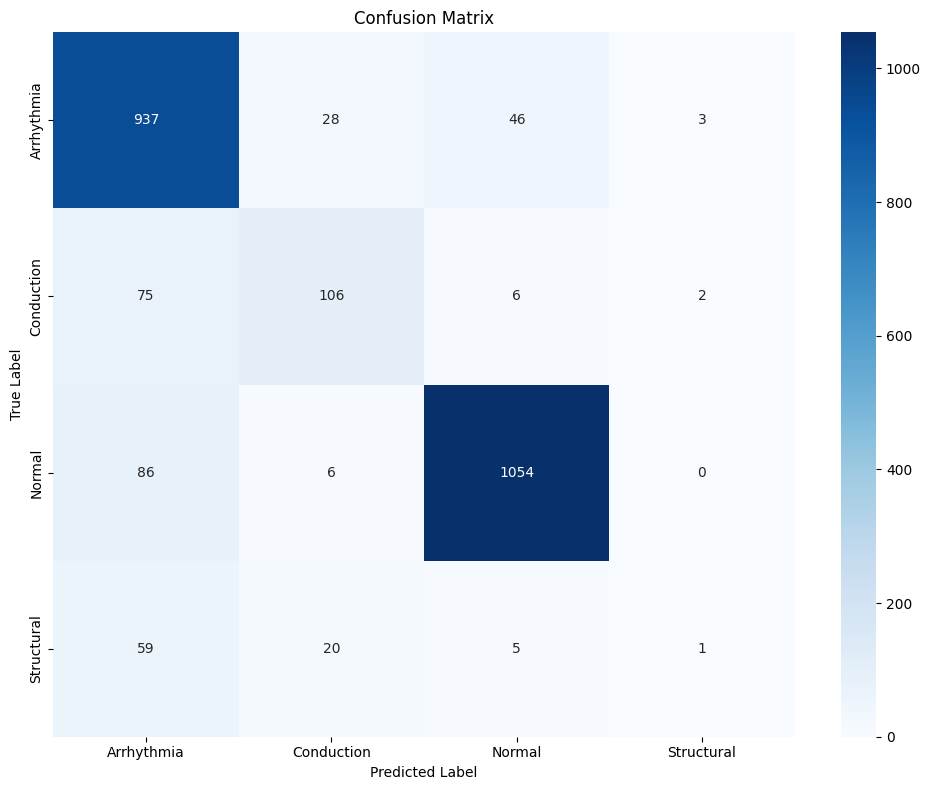

              precision    recall  f1-score   support

  Arrhythmia       0.81      0.92      0.86      1014
  Conduction       0.66      0.56      0.61       189
      Normal       0.95      0.92      0.93      1146
  Structural       0.17      0.01      0.02        85

    accuracy                           0.86      2434
   macro avg       0.65      0.60      0.61      2434
weighted avg       0.84      0.86      0.85      2434



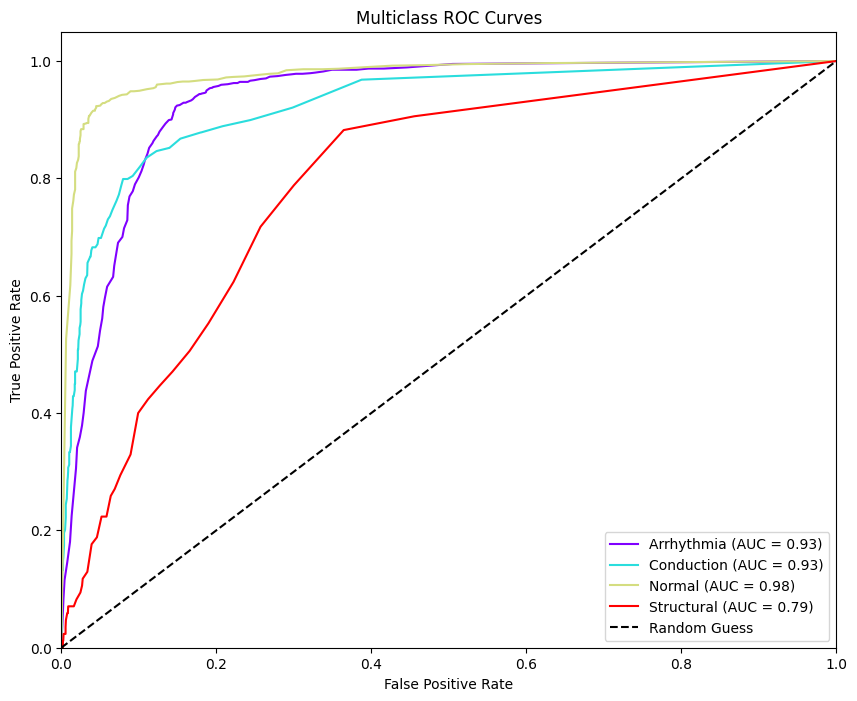

{0: 0.9346296219129373,
 1: 0.9252966615995569,
 2: 0.975433386990125,
 3: 0.7915207973355369}

In [8]:
# RF Evaluation
visualizer = RF_pipeline.ModelVisualizer()
y_pred_rf = rf_model.predict(X_val_RF)
y_pred_rf_proba = rf_model.predict_proba(X_val_RF)
visualizer.plot_multiclass_confusion_matrix(val_labels, y_pred_rf, list(categories))
visualizer.plot_multiclass_roc(val_labels, y_pred_rf_proba, list(categories))


### 5.2 CNN performance



77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


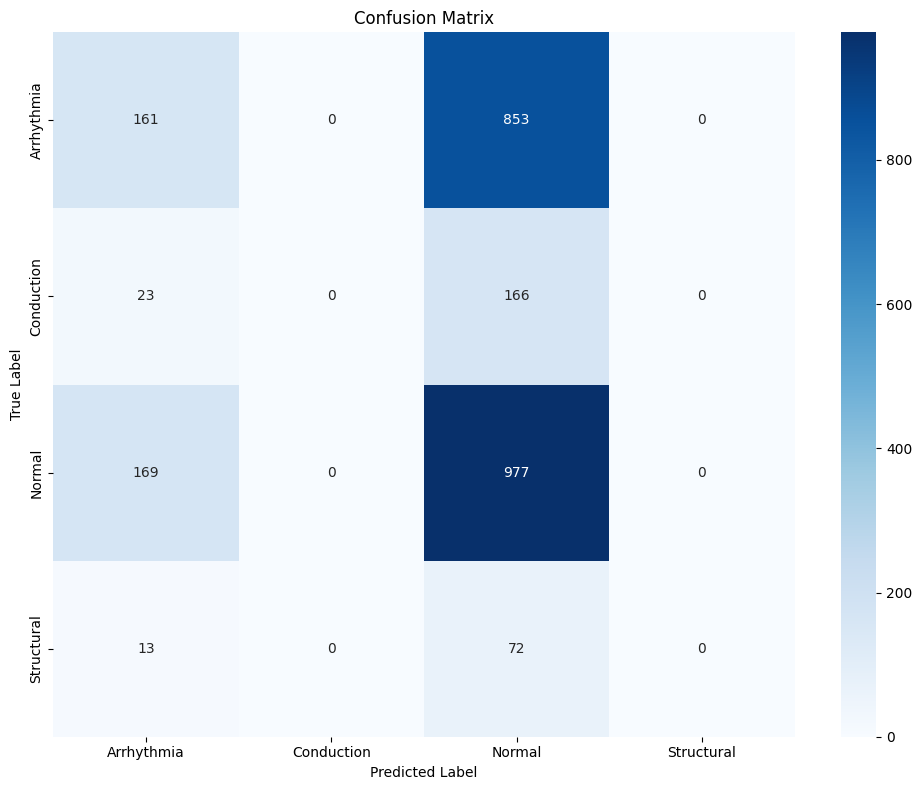

              precision    recall  f1-score   support

  Arrhythmia       0.44      0.16      0.23      1014
  Conduction       0.00      0.00      0.00       189
      Normal       0.47      0.85      0.61      1146
  Structural       0.00      0.00      0.00        85

    accuracy                           0.47      2434
   macro avg       0.23      0.25      0.21      2434
weighted avg       0.41      0.47      0.38      2434



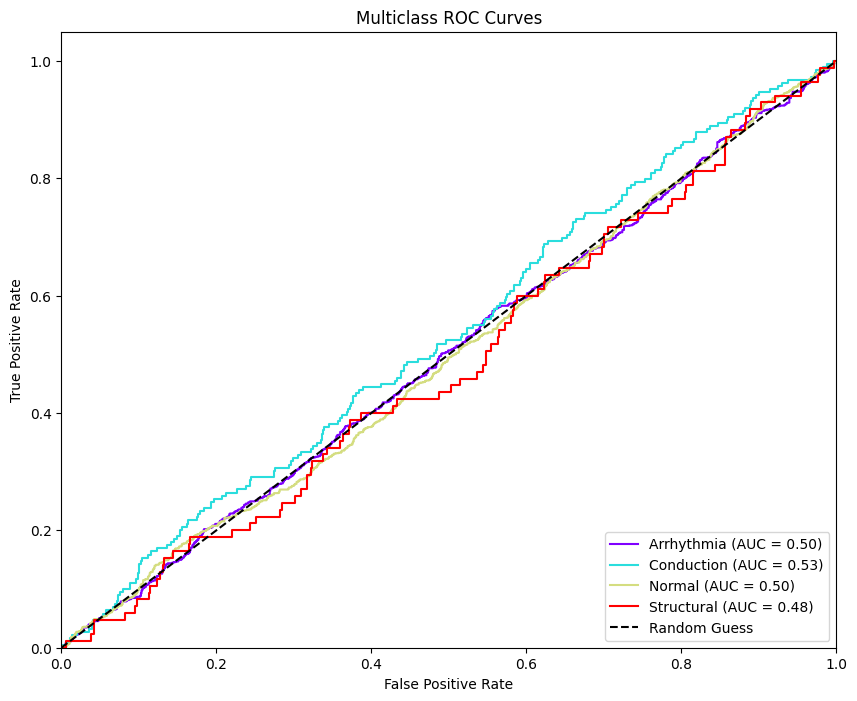

{0: 0.5000052087673973,
 1: 0.5327370641401822,
 2: 0.4958839414436387,
 3: 0.4837953572233492}

In [9]:
# CNN Evaluation 
y_pred_cnn = cnn_model.predict(X_val_CNN)
visualizer.plot_multiclass_confusion_matrix(y_val_CNN, np.argmax(y_pred_cnn, axis=1), list(categories))
visualizer.plot_multiclass_roc(y_val_CNN, y_pred_cnn, list(categories))